In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import sklearn.preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
FILE = 'results/cudnn/conv.csv'

In [2]:
def load_csv(file):
    df = pd.read_csv(file)
    return df

In [3]:
def one_hot_encode(df):
    precision = pd.get_dummies(df.precision)
    fwd_algo = pd.get_dummies(df.fwd_algo)
    sm_cap = pd.get_dummies(df.sm_cap)
    cuda_version = pd.get_dummies(df.cuda_version)
    df.drop(columns=['precision', 'fwd_algo', 'sm_cap', 'cuda_version'], inplace=True)
    df = pd.concat([df, precision, fwd_algo, sm_cap, cuda_version], axis=1)

    print(f'New encoded columns: {precision.columns, fwd_algo.columns, sm_cap.columns, cuda_version.columns}')
    return df

In [4]:
def normalize(X, y):
    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(X))
    y = pd.Series(ss.fit_transform(np.array(y).reshape(-1,1))[:,0])
    return X, y


In [5]:
df = load_csv(FILE)
df = one_hot_encode(df)
print(df.info())
print(df.describe())

New encoded columns: (Index(['float', 'half', 'int8'], dtype='object'), Index(['FFT', 'FFT_TILING', 'GEMM', 'IMPLICIT_GEMM', 'IMPLICIT_PRECOMP_GEMM',
       'WINOGRAD', 'WINOGRAD_NONFUSED'],
      dtype='object'), Index(['"6.1"', '"7.0"', '"7.5"'], dtype='object'), Index(['"10.1"', '"11.2"', '"11.3"'], dtype='object'))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52337 entries, 0 to 52336
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   w                                52337 non-null  int64
 1   h                                52337 non-null  int64
 2   c                                52337 non-null  int64
 3   n                                52337 non-null  int64
 4   k                                52337 non-null  int64
 5   f_w                              52337 non-null  int64
 6   f_h                              52337 non-null  int64
 7   pad_w                    

In [6]:
# Drop columns that only have one value (i.e. same number of threads per block across all architectures, etc)
unique = df.nunique() == 1
drop_idx = unique[unique == True].index.array
df.drop(columns=drop_idx, inplace=True)
print('Dropped columns: ', drop_idx)

<PandasArray>
[                'total_const_mem',      'total_shared_mem_per_block',
         'total_num_reg_per_block',                       'warp_size',
           'max_threads_per_block',                 'gpu_sharing_mem',
            'host_page_locked_mem',                     'ecc_support',
              'unified_addressing',              'compute_preemption',
       'cooperative_kernel_launch', 'multi_device_cooperative_kernel']
Length: 12, dtype: object

array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'f_w'}>],
       [<AxesSubplot:title={'center':'f_h'}>,
        <AxesSubplot:title={'center':'pad_w'}>,
        <AxesSubplot:title={'center':'pad_h'}>,
        <AxesSubplot:title={'center':'stride_w'}>,
        <AxesSubplot:title={'center':'stride_h'}>,
        <AxesSubplot:title={'center':'fwd_time(usec)'}>],
       [<AxesSubplot:title={'center':'pad_kernels'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>,
        <AxesSubplot:title={'center':'cuda_cores'}>,
        <AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>],
       [<AxesSubplot:title={'center':'l2_cache_size'}>,
        <AxesSubplot:title={'c

<Figure size 432x288 with 0 Axes>

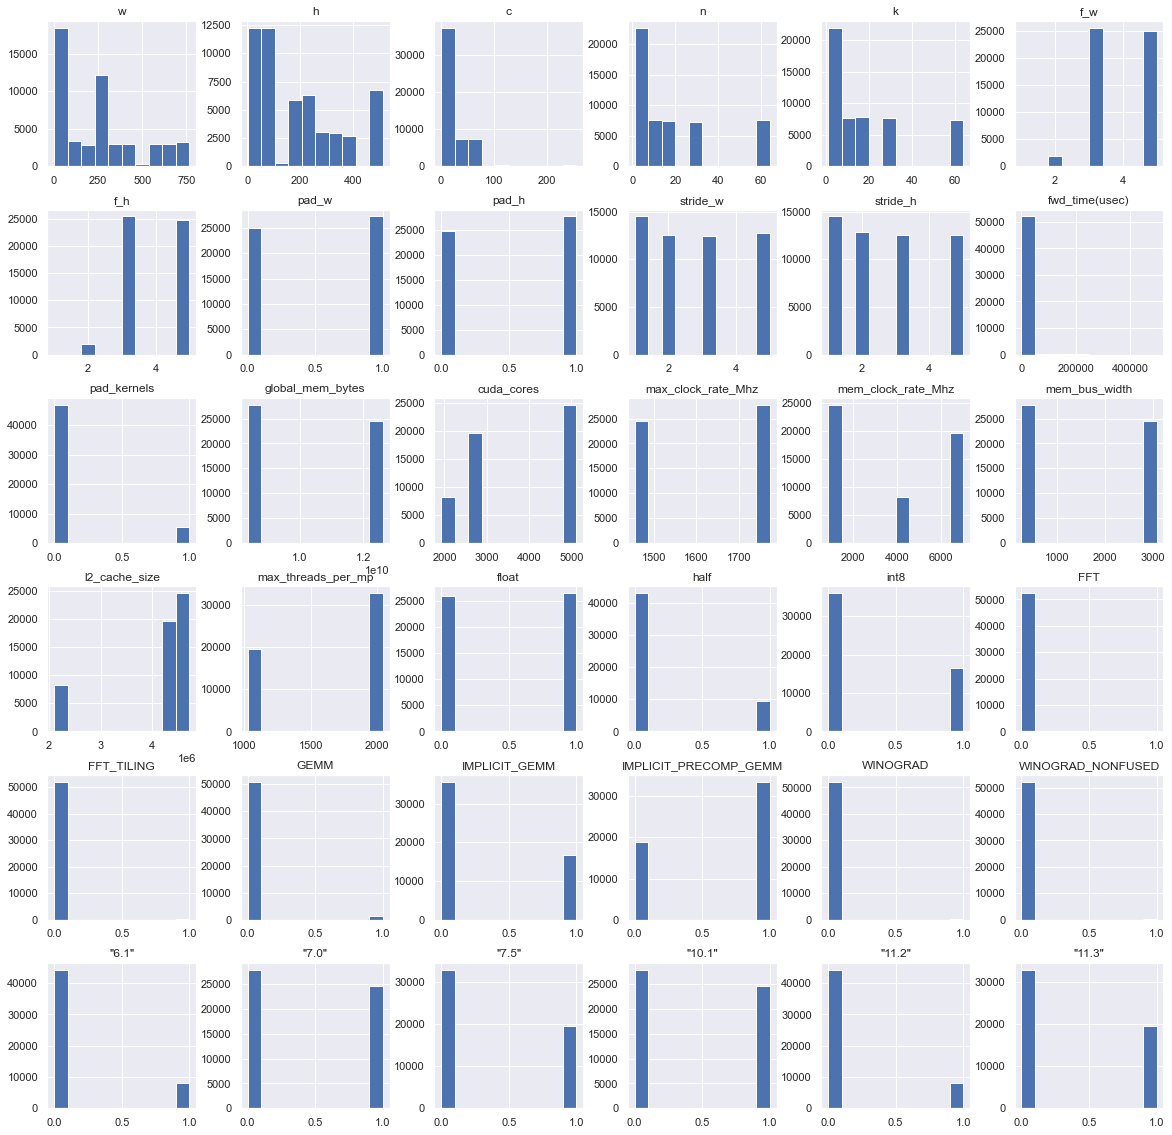

In [8]:
fig = plt.figure()
df.hist(figsize=(20,20))

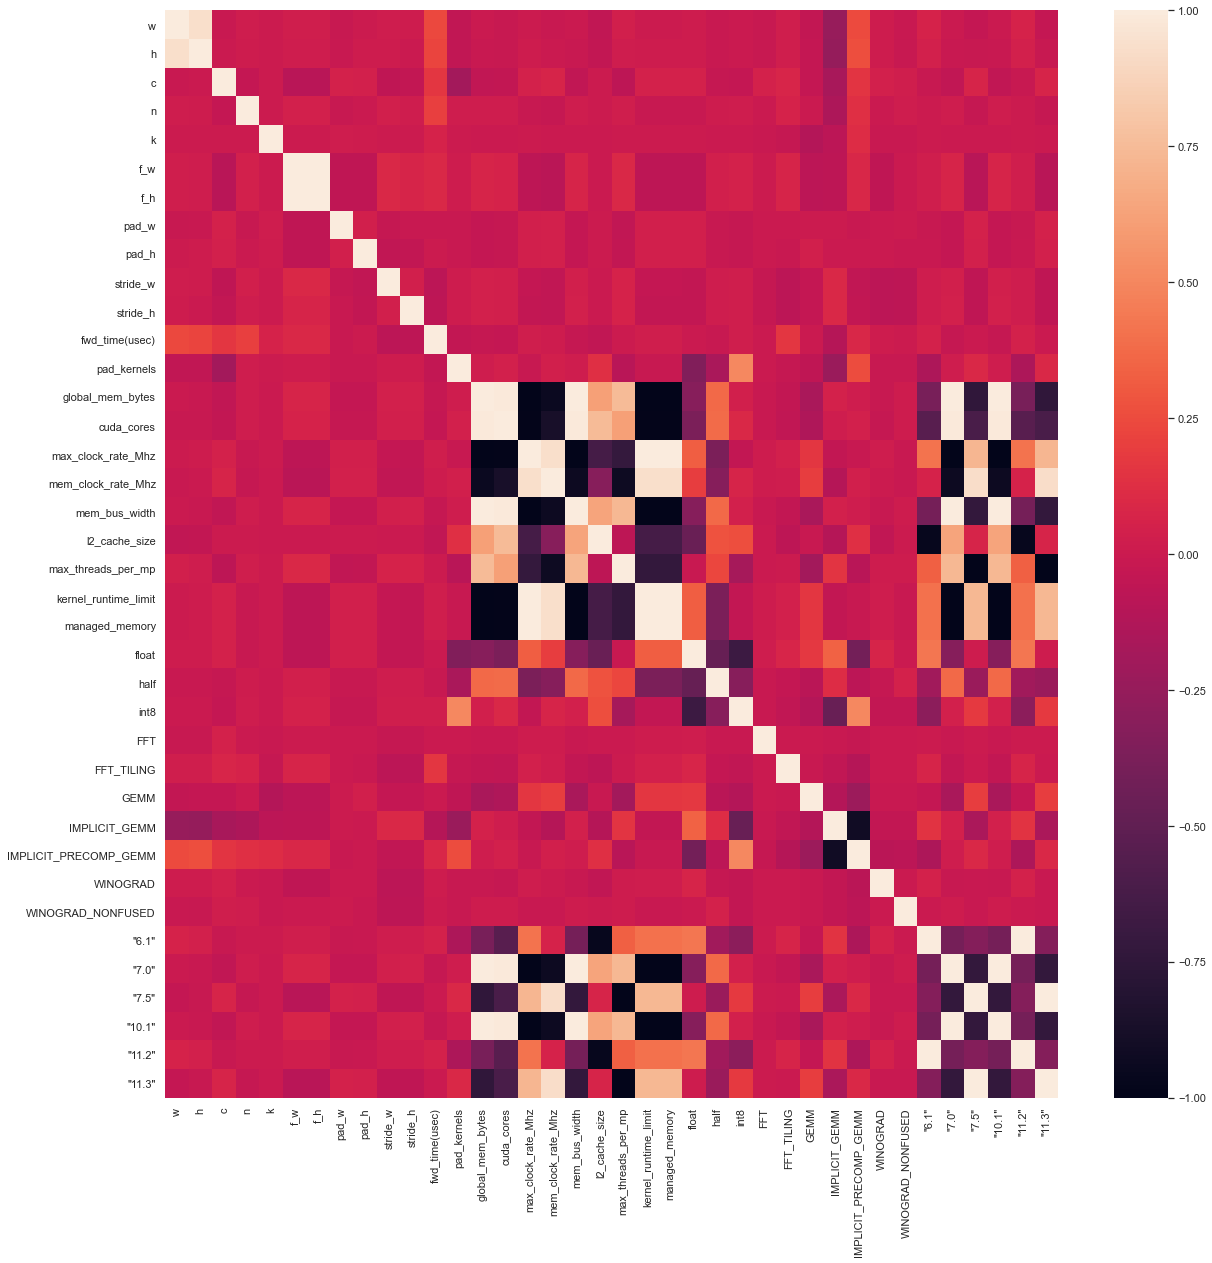

In [9]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [10]:
y = df['fwd_time(usec)']
X = df.drop(columns=['fwd_time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [11]:
clf = MLPRegressor(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.7484748128574502

In [12]:
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.19243635325048947

In [13]:
clf = Ridge()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.19243649355643444

In [14]:
clf = Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.11532575444197124

In [15]:
clf = SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5046256755460572

In [16]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4192319904415289

In [17]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5601357956325169

In [18]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.812497430676335

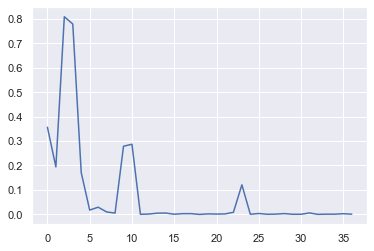

In [19]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(random_forest_result.importances_mean)

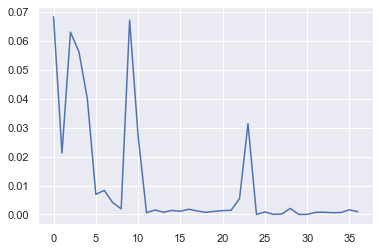

In [20]:
plt.plot(random_forest_result.importances_std)

In [36]:
importances = pd.Series(random_forest_result.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index
print('Most "important" columns in dataset: ')
df.columns[idx]

Most "important" columns in dataset: 


Index(['c', 'n', 'w', 'stride_h', 'stride_w', 'h', 'k', 'half', 'f_h', 'f_w',
       'pad_w', 'float', 'WINOGRAD_NONFUSED', 'cuda_cores', 'pad_h',
       'global_mem_bytes', 'FFT'],
      dtype='object')

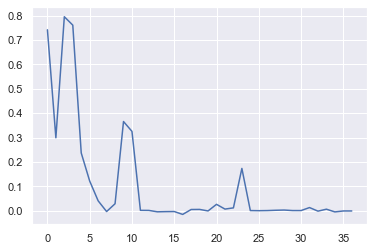

In [22]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(decision_tree_results.importances_mean)

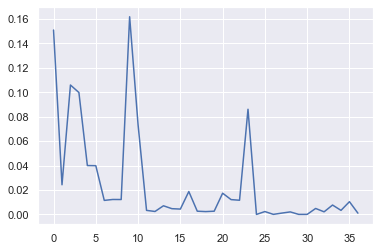

In [23]:
plt.plot(decision_tree_results.importances_std)

In [37]:
importances = pd.Series(decision_tree_results.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index
print('Most "important" columns in dataset: ')
df.columns[idx]

Most "important" columns in dataset: 


Index(['c', 'n', 'w', 'stride_w', 'stride_h', 'h', 'k', 'half', 'f_w', 'f_h',
       'pad_h', 'kernel_runtime_limit', 'WINOGRAD_NONFUSED', 'float',
       'managed_memory', '"7.0"', 'l2_cache_size', 'mem_bus_width'],
      dtype='object')

2     0.795918
3     0.761471
0     0.742350
9     0.365624
10    0.325168
1     0.298911
4     0.236420
23    0.173065
5     0.121163
6     0.040016
8     0.027988
20    0.025578
31    0.012307
22    0.011026
21    0.006074
33    0.005619
18    0.004701
17    0.004319
dtype: float64